In [2]:
import pandas as pd

dataset = pd.read_csv('avalanche.csv', delimiter = '\t')
dataset.head()

,Unnamed: 0,avalanche,no_visitors,surface_hoar,fresh_thickness,wind,weak_layers,tracked_out
0,0,0,4,3.900508,8.715485,6,9,0
1,1,0,9,1.477586,6.801417,30,0,0
2,2,1,3,3.236594,5.632457,8,8,1
3,3,0,0,3.244283,9.348871,12,10,0
4,4,1,2,5.196741,3.782315,4,9,1


The avalanche feature is or target, 0 means no avalanche and 1 means avalanche. The other features are the weather conditions.

So we will use binary classification model

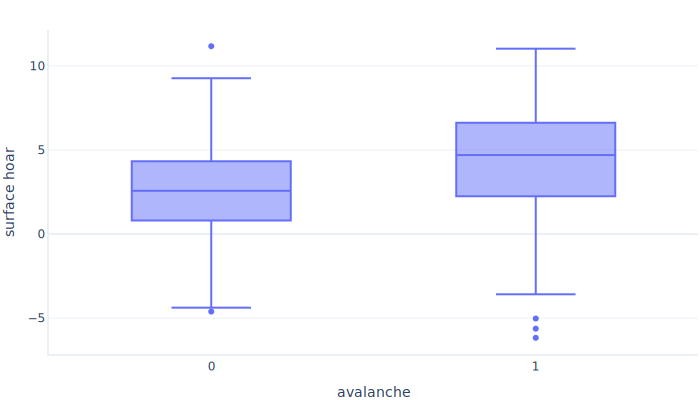

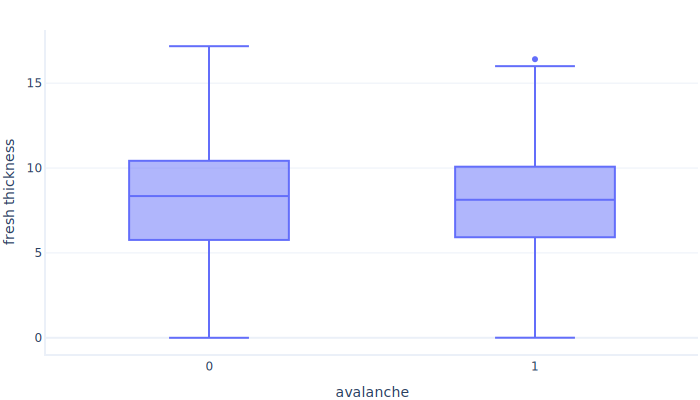

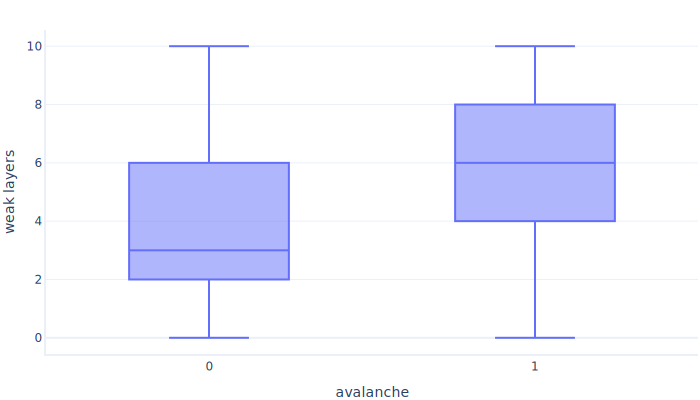

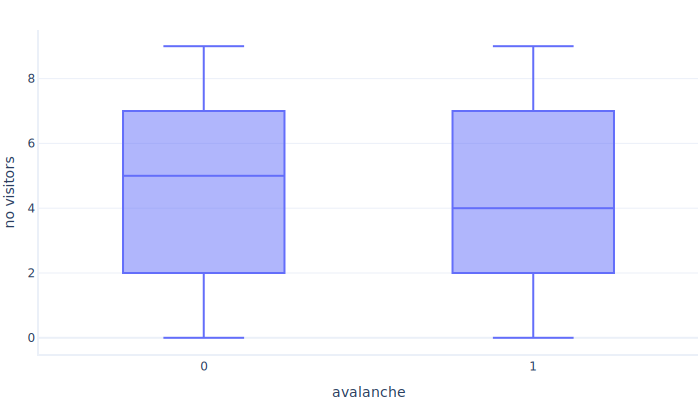

In [5]:
import graphing as gr
import plotly.io as pio

pio.renderers.default = 'svg'

gr.box_and_whisker(dataset, label_x='avalanche', label_y='surface_hoar', show=True)
gr.box_and_whisker(dataset, label_x='avalanche', label_y='fresh_thickness', show=True)
gr.box_and_whisker(dataset, label_x='avalanche', label_y='weak_layers', show=True)
gr.box_and_whisker(dataset, label_x='avalanche', label_y='no_visitors')

### Build a simple logistic regression model

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.3, random_state=2)
print('Train: ', train.shape)
print('Test: ', test.shape)

Train:  (766, 8)
Test:  (329, 8)


In [7]:
import statsmodels.formula.api as smf

model = smf.logit('avalanche ~ weak_layers', train).fit()

Optimization terminated successfully.
         Current function value: 0.631451
         Iterations 5


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  766
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 Mar 2023   Pseudo R-squ.:                 0.07898
Time:                        14:08:58   Log-Likelihood:                -483.69
converged:                       True   LL-Null:                       -525.17
Covariance Type:            nonrobust   LLR p-value:                 8.395e-20
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8586      0.147     -5.856      0.000      -1.146      -0.571
weak_layers     0.2241      0.026      8.648      0.000       0.173       0.275
===============================================================================
"""

Notice that the positive coefficient for weak_layers means that a higher value means a higher likelihood for an avalanche.

In [9]:
# predict to get a probability

# get the first 3 samples from dataset
samples = test['weak_layers'][:4]

# use the model to predict the probability of avalanche
estimated_prob = model.predict(samples)

for sample, pred in zip(samples, estimated_prob):
    print('Weak Layers: ', sample)
    print('Probability of avalanche: ', pred*100)
    print('')

Weak Layers:  5
Probability of avalanche:  56.51379879785626

Weak Layers:  4
Probability of avalanche:  50.9476679940887

Weak Layers:  7
Probability of avalanche:  67.04676581785758

Weak Layers:  0
Probability of avalanche:  29.76301844190223



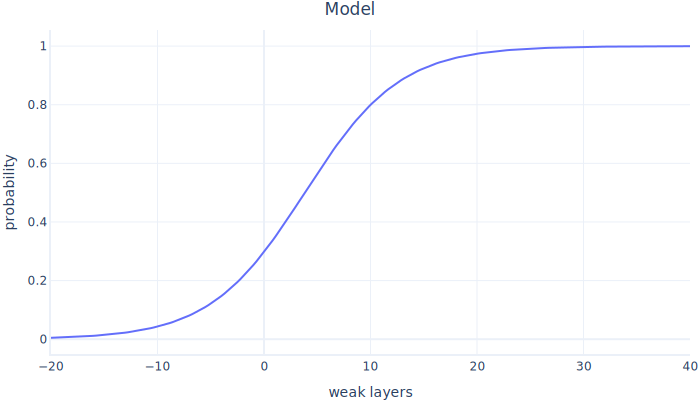

In [11]:
predict = lambda x: model.predict(pd.DataFrame({'weak_layers': x}))

gr.line_2D([('Model', predict)], x_range=[-20,40], label_x='weak_layers', label_y='probability')

In [12]:
print("Minimum number of weak layers:", min(train.weak_layers))
print("Maximum number of weak layers:", max(train.weak_layers))

Minimum number of weak layers: 0
Maximum number of weak layers: 10


The fact the model shows range [-20, 10+] is because logistic regression models allow predictions outside the range of values they have seen, and sometimes do so quite well.

The second reason the plot is confusing is that at 0 layers, there's still some risk of an avalanche. Similarly, at 10 layers, there isn't a 100% risk of an avalanche. This is actually in line with the data:

In [13]:
import numpy as np

# Get actual rates of avalanches at 0 years
avalanche_outcomes_for_0_layers = train[train.weak_layers == 0].avalanche
print("Average rate of avalanches for 0 weak layers of snow", np.average(avalanche_outcomes_for_0_layers))

# Get actual rates of avalanches at 10 years
avalanche_outcomes_for_10_layers = train[train.weak_layers == 10].avalanche
print("Average rate of avalanches for 10 weak layers of snow", np.average(avalanche_outcomes_for_10_layers))

Average rate of avalanches for 0 weak layers of snow 0.3880597014925373
Average rate of avalanches for 10 weak layers of snow 0.7761194029850746


Our model is actually doing a good job! It's just that avalanches aren't only caused by weak layers of snow. If we want to do better, we probably need to think about including other information in the model.

### Classification or decision thresholds

To return a binary category (True = "avalanche", False = "no avalanche") we need to define a Classification Threshold value. Any probability above that threshold is returned as the positive category, whereas values below it will be returned as the negative category.

Let's see what happens if set our threshold to 0.5 (meaning that our model will return True whenever it calculates a chance above 50% of an avalanche happening):

In [14]:
threshold = 0.5

# Add classification to the samples used before
for sample, pred in list(zip(samples, estimated_prob)):
    print('Weak Layers: ', sample)
    print('Probability of avalanche: ', pred*100)
    print('Classification: ', 'avalanche' if pred >= threshold else 'no avalanche')
    print('')

Weak Layers:  5
Probability of avalanche:  56.51379879785626
Classification:  avalanche

Weak Layers:  4
Probability of avalanche:  50.9476679940887
Classification:  avalanche

Weak Layers:  7
Probability of avalanche:  67.04676581785758
Classification:  avalanche

Weak Layers:  0
Probability of avalanche:  29.76301844190223
Classification:  no avalanche



Note that a 0.5 threshold is just a starting point that needs to be tuned depending on the data we're trying to classify.

### Performance on test set

Now let's use our test dataset to perform a quick evaluation on how the model did. For now, we'll just look at how often we correctly predicted if there would be an avalanche or not

In [15]:
predictions = model.predict(test) > threshold

accuracy = np.average(predictions == test.avalanche)

print(f"The model correctly predicted outcomes {accuracy * 100:.2f}% of time.")

The model correctly predicted outcomes 65.05% of time.



Avalanches are hard to pick but we're doing ok. It's hard to tell exactly what kind of mistakes our model is making, though. We'll focus on this in the next exercise.

## Assessing a logistic regression model

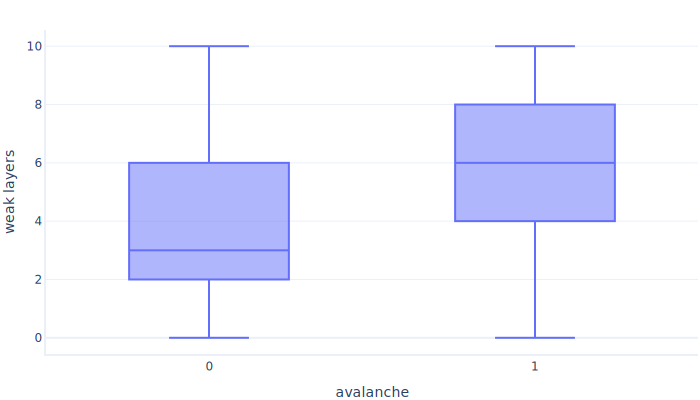

In [16]:
gr.box_and_whisker(dataset, label_x='avalanche', label_y='weak_layers')


It seems that avalanches are associated with having more weak layers of snow. That said, some days many weak layers have been recorded, but no avalanche occurred. This means our model will have difficulty being extremely accurate using only this feature. Let's continue though, and come back to this in a future exercise.

Before we begin, we need to split our dataset into training and test sets. We will train on the training set, and test on (you guessed it) the test set.

In [17]:
train, test = train_test_split(dataset, test_size=0.25, random_state=10)

In [18]:
model = smf.logit('avalanche ~ weak_layers', train).fit()

Optimization terminated successfully.
         Current function value: 0.616312
         Iterations 5


In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      819
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 Mar 2023   Pseudo R-squ.:                  0.1018
Time:                        15:08:43   Log-Likelihood:                -505.99
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 9.269e-27
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0656      0.148     -7.207      0.000      -1.355      -0.776
weak_layers     0.2643      0.026      9.985      0.000       0.212       0.316
===============================================================================
"""

Two useful pieces of information are in the bottom row. The coef for weak_layers is positive, which means that as weak_layers increases, so does the probability of an avalanche. The the P value column is less than 0.05, which means the model is confident that weak_layers is a useful predictor of avalanches.

The rest of this table, however, is difficult to understand for beginners and so it's not clear how well our model is working. Let's try another way.

### Assessing model visually

Sometimes, but not always, we can visually assess a logistic regression mode. Let's plot our model against the actual data in the test dataset.



In [20]:
def predict(weak_layers):
    return model.predict(dict(weak_layers=weak_layers))

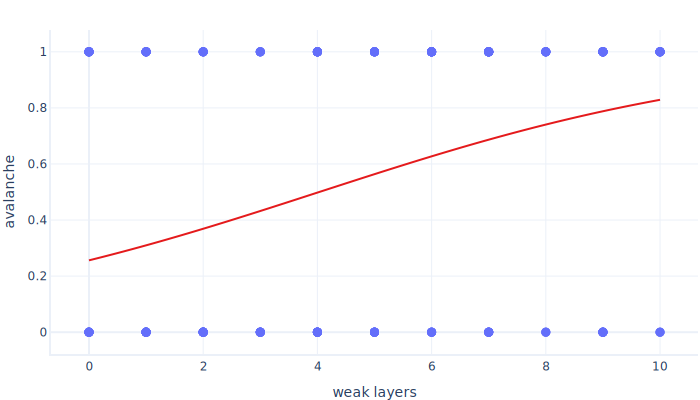

In [21]:
gr.scatter_2D(test, label_x='weak_layers', label_y='avalanche', trendline=predict)

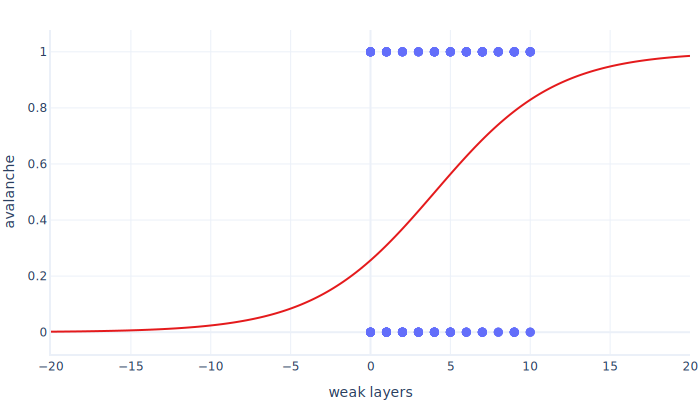

In [22]:
gr.scatter_2D(test, label_x='weak_layers', label_y='avalanche', x_range=[-20,20], trendline=predict)

Checking the earlier graph, we can see that our model will predict an avalanche when the number of weak layers of snow is greater than 5. We can tell this because the value of the line is 0.5 at x=5 (remember that in the previous unit we defined a classifier threshold, so that probabilities over 0.5 would be classified as True).

How this relates with points is hard to tell - the points overlap and so it is difficult to see how many points are at 0 or at 1. How else can we assess the model?

### Assess with cost function

Let's assess our model with a log-loss cost function.

In [23]:
from sklearn.metrics import log_loss

predictions = model.predict(test)

# Print the log loss
print("Log loss:", log_loss(test.avalanche, predictions))

Log loss: 0.6803588691541006


0.66 - what does that mean? This could be useful to compare two different models, but it's hard to get a grasp on exactly what this means for real-world performance.

### Assess accuracy

Let's instead assess accuracy. Accuracy refers to the proportion of predictions the model got correct, after predictions are converted from probabilities to avalanche or no-avalanche.

The first thing to do is convert probabilities to hard predictions:

In [25]:
# Print a few predictions before we convert them to categories
print(f"First three predictions (probabilities): {predictions.iloc[0]}, {predictions.iloc[1]}, {predictions.iloc[2]}")

# convert to absolute values
avalanche_predicted = predictions >= 0.5

# Print a few predictions converted into categories
print(f"First three predictions (categories): {avalanche_predicted.iloc[0]}, {avalanche_predicted.iloc[1]}, {avalanche_predicted.iloc[2]}")

First three predictions (probabilities): 0.788017694282122, 0.6866335148335762, 0.5636126304803127
First three predictions (categories): True, True, True


In [27]:
# Calculate what proportion were predicted correctly
guess_was_correct = test.avalanche == avalanche_predicted
accuracy = np.average(guess_was_correct)

# Print the accuracy
print("Accuracy for whole test dataset:", accuracy)

Accuracy for whole test dataset: 0.6167883211678832


It looks like it's predicting the correct answer 61% of the time. This is helpful information. What kind of mistakes is it making, though? Let's take a look at whether it is guessing avalanche when there are none (false positives), or failing to guess 'avalanche' when one actually occurs (false negative):

In [33]:
# False Negative: calculate how often it guessed no avalanche when one actually occurred
false_negative = np.average(np.logical_not(guess_was_correct) & test.avalanche)

# False positive: calculate how often it guessed avalanche, when none actually happened
false_positive = np.average(np.logical_not(guess_was_correct) & np.logical_not(test.avalanche))


print(f"Wrongly predicted an avalanche {false_positive * 100}% of the time")
print(f"Failed to predict avalanches {false_negative * 100}% of the time")

Wrongly predicted an avalanche 17.153284671532848% of the time
Failed to predict avalanches 21.16788321167883% of the time
